<a href="https://colab.research.google.com/github/ArnaudFEYEL/Forecasting-Sneaker-Profitability-using-the-Stock-X-Dataset/blob/main/M2Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project

*Maud* JACQUOT

Arnaud FEYEL

# Introduction

For the past decade, the resell market has become one of the most lucrative market for teens and young adults. In particular, the sneaker resell market has evolved from a niche subculture into a thriving global industry, reflecting the intersection of fashion, technology, and consumer culture. Characterized by enthusiasts buying and selling coveted athletic footwear at prices often exceeding their retail value, this market has experienced explosive growth in recent years. The rise of online platforms and mobile apps such as WeTheNew and StockX have democratized access to this market, connecting buyers and sellers worldwide and fueling a dynamic marketplace.

We decided to study a dataset from StockX. Our main goal is to estimate the profit of a sneaker according to its different characteristics like its size, colors, brand, the model and so on. This dataset has already been studied by other people using a lot of different complicated and unknown python packages that are not available anymore. We decided to start from scratch our study only using the native packages available in Python 3. This work can be generalized to all kinds of linear regression models that aim to estimate a value, in Finance or even in the industry to predict the cost/profit of a product. Human expertise could be required at the first, but our main goal is to make the most reliable profit prediction

### Data loading


In [ ]:
#We import all the necessary packages
import platform
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from matplotlib.colors import ListedColormap
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso, LassoCV, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score,mean_squared_error
from sklearn.neural_network import MLPRegressor
from scipy.stats import zscore, randint
import requests
from io import BytesIO
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier

In [ ]:
url = "https://github.com/davidtassignon/StockX_Sneakers_Project/raw/main/CSV_files/StockX-Data-Contest-2019.xlsx"

response = requests.get(url)
excel_data = response.content

df = pd.read_excel(BytesIO(excel_data), sheet_name=0)

df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


# I) Preprocessing of the dataset

We began by examining our dataset to identify missing values. After calculating the total number of rows, we replaced empty cells with NaN (Not A Number) values and subsequently deleted the corresponding entries. This step is crucial to ensure data quality and prevent errors during subsequent analysis.

In [ ]:
n=df.shape[0]
df.replace('', np.nan, inplace=True)
df = df.dropna()
(n-df.shape[0])/n
#no Nan value

0.0

In order to ensure code consistency and clarity, we proceeded with renaming certain columns. For instance, column names containing spaces or special characters were modified to adhere to a uniform naming convention. This step facilitates variable referencing in the code and reduces the risk of input errors.

In [ ]:
#Renaming the columns to avoid name issues in the code
df = df.rename(columns={'Order Date': 'Order_Date', 'Sneaker Name': 'Sneaker_Name'
                       , 'Sale Price' : 'Sale_Price', 'Retail Price' : 'Retail_Price'
                       , 'Release Date': 'Release_Date', 'Shoe Size' : 'Shoe_Size',
                       'Buyer Region': 'Buyer_Region'})
df.head()

,Order_Date,Brand,Sneaker_Name,Sale_Price,Retail_Price,Release_Date,Shoe_Size,Buyer_Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


The sale and retail prices were initially stored as strings with currency symbols. To facilitate subsequent calculations, we converted this data into integers by removing the currency symbols. Using these values, we calculated the profit for each transaction by subtracting the retail price from the sale price. This 'Profit' variable will be our target during data analysis.

In [ ]:
#Transforming prices features in integer and creating our target : Profit
df['Sale_Price'] = df['Sale_Price'].replace('[\$,]', '', regex=True).astype(int)
df['Retail_Price'] = df['Retail_Price'].replace('[\$,]', '', regex=True).astype(int)
df['Profit'] = df['Sale_Price'] - df['Retail_Price']
df = df.drop(['Sale_Price','Retail_Price'],axis=1)
df.head()

,Order_Date,Brand,Sneaker_Name,Release_Date,Shoe_Size,Buyer_Region,Profit
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,2016-09-24,11.0,California,877
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,2016-11-23,11.0,California,465
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,2016-11-23,11.0,California,470
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,2016-11-23,11.5,Kentucky,855
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,2017-02-11,11.0,Rhode Island,608


The order and release dates of sneakers were initially stored each in a single column. For a more detailed temporal analysis, we separated these dates into three distinct columns representing the day, month, and year. Additionally, we added a variable 'Days\_After' indicating the number of days between the release date of the sneaker and the day of resale. These transformations will enable us to explore seasonal trends and variations in purchasing behavior over time.

In [ ]:
#Transforming Order_Date column in 3 columns : day, month and year
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%m/%d/%y')

df['Order_Day'] = df['Order_Date'].dt.day
df['Order_Month'] = df['Order_Date'].dt.month
df['Order_Annee'] = df['Order_Date'].dt.year

#Transforming Release_Date column in 3 columns : day, month and year
df['Release_Date'] = pd.to_datetime(df['Release_Date'], format='%m/%d/%y')

df['Release_Day'] = df['Release_Date'].dt.day
df['Release_Month'] = df['Release_Date'].dt.month
df['Release_Annee'] = df['Release_Date'].dt.year
df['Days_After'] = (df['Order_Date'] - df['Release_Date']).dt.days
df.head()

,Order_Date,Brand,Sneaker_Name,Release_Date,Shoe_Size,Buyer_Region,Profit,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,2016-09-24,11.0,California,877,1,9,2017,24,9,2016,342
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,2016-11-23,11.0,California,465,1,9,2017,23,11,2016,282
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,2016-11-23,11.0,California,470,1,9,2017,23,11,2016,282
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,2016-11-23,11.5,Kentucky,855,1,9,2017,23,11,2016,282
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,2017-02-11,11.0,Rhode Island,608,1,9,2017,11,2,2017,202


Each sneaker is associated with a specific model and color, which significantly impacts its value in the resale market. To capture this information more accurately, we extracted the model and color of each sneaker from its name. This step will allow us to include more detailed features in our analysis model.

In [ ]:
#Extracting model and color for each sneaker to get a more precise description of each sneaker
data = {'Sneaker_Name': df['Sneaker_Name'].tolist()}
SN = pd.DataFrame(data)

def extraire_model_color(nom_chaussure):
    color_speciaux = {'Core-Black-White': 'Core-Black-White', 'Core-Black-Green': 'Core-Black-Green','Core-Black-Copper':'Core-Black-Copper','Core-Black-Red':'Core-Black-Red','Core-Black-Red-2017':'Core-Black-Red-2017','Cream-White':'Cream-White','Pirate-Black-2016':'Pirate-Black-2016','Oxford-Tan':'Oxford-Tan','Turtledove':'Turtledove','Pirate-Black-2015':'Pirate-Black-2015','Semi-Frozen-Yellow':'Semi-Frozen-Yellow','Beluga-2pt0':'Beluga-2.0','Blue-Tint':'Blue-Tint','University-Blue':'University-Blue','Total-Orange':'Total-Orange','Elemental-Rose-Queen':'Elemental-Rose-Queen','All-Hallows-Eve':'All-Hallows-Eve','Grim-Reaper':'Grim-Reaper','Wolf-Grey':'Wolf-Grey','Black-Silver':'Black-Silver','Black-White':'Black-White','Static-Reflective':'Static-Reflective','Desert-Ore':'Desert-Ore'}

    for color_special, remplacement in color_speciaux.items():
        if color_special in nom_chaussure:
            model = nom_chaussure.replace(color_special, '').strip('-')
            color = remplacement.strip('-')
            return model, color

    if 'Off-White' in nom_chaussure:
        index_off_white = nom_chaussure.find('Off-White')
        if index_off_white + len('Off-White') == len(nom_chaussure):
            model = nom_chaussure[:index_off_white].strip('-')
            color = nom_chaussure[index_off_white + len('Off-White'):].strip('-')
            return model, color

    last_dash_index = nom_chaussure.rfind('-')
    model = nom_chaussure[:last_dash_index]
    color = nom_chaussure[last_dash_index + 1:]

    return model, color

df[['Model', 'Color']] = df['Sneaker_Name'].apply(extraire_model_color).apply(pd.Series)

Qualitative variables such as model, color, and buyer region were factorized to convert them into numerical data. This transformation is necessary to utilize these variables in machine learning algorithms. We assigned a unique code to each category, enabling our analysis model to interpret them effectively.

In [ ]:
#Factorisation of qualitative data
df['Model_Code'],_ = pd.factorize(df['Model'])
df['Color_Code'],_ = pd.factorize(df['Color'])
df.head()

,Order_Date,Brand,Sneaker_Name,Release_Date,Shoe_Size,Buyer_Region,Profit,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After,Model,Color,Model_Code,Color_Code
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,2016-09-24,11.0,California,877,1,9,2017,24,9,2016,342,Adidas-Yeezy-Boost-350-Low-V2,Beluga,0,0
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,2016-11-23,11.0,California,465,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Copper,1,1
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,2016-11-23,11.0,California,470,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Green,1,2
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,2016-11-23,11.5,Kentucky,855,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Red,1,3
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,2017-02-11,11.0,Rhode Island,608,1,9,2017,11,2,2017,202,Adidas-Yeezy-Boost-350-V2--2017,Core-Black-Red,2,3


In our dataset, the brand 'Off-White' was transformed into 0 and 'Yeezy' into 1. This step simplifies data processing by converting brands into binary values. These values will be easier to handle during modeling and statistical analysis. We do the same for Sneaker_Name and Buyer_Region.


In [ ]:
df['Brand'].replace('Off-White', 0, inplace=True)
df['Brand'].replace(' Yeezy', 1, inplace=True)
df['Sneaker_Code'],_ = pd.factorize(df['Sneaker_Name'])
df['Buyer_Code'],_ = pd.factorize(df['Buyer_Region'])
df.head()

,Order_Date,Brand,Sneaker_Name,Release_Date,Shoe_Size,Buyer_Region,Profit,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After,Model,Color,Model_Code,Color_Code,Sneaker_Code,Buyer_Code
0,2017-09-01,1,Adidas-Yeezy-Boost-350-Low-V2-Beluga,2016-09-24,11.0,California,877,1,9,2017,24,9,2016,342,Adidas-Yeezy-Boost-350-Low-V2,Beluga,0,0,0,0
1,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,2016-11-23,11.0,California,465,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Copper,1,1,1,0
2,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,2016-11-23,11.0,California,470,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Green,1,2,2,0
3,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,2016-11-23,11.5,Kentucky,855,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Red,1,3,3,1
4,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,2017-02-11,11.0,Rhode Island,608,1,9,2017,11,2,2017,202,Adidas-Yeezy-Boost-350-V2--2017,Core-Black-Red,2,3,4,2


In [ ]:
#Checking that there isnt any NA value after the creation of new features
n=df.shape[0]
df.replace('', np.nan, inplace=True)
print("Before dropping rows with NA values:\n", df.shape[0])

#Dropping rows with NA values
df = df.dropna(how='any')


print("After dropping rows with NA values:\n", df.shape[0])
print("percentage of na value ",((n-df.shape[0])/n)*100,'%')

Before dropping rows with NA values:
 99956
After dropping rows with NA values:
 95768
percentage of na value  4.1898435311537074 %


Finally, after performing these transformations, we observed that the number of rows in the dataset decreased from 99956 to 95768 after removing missing values, representing approximately 4.19% of the initial data.

# II) Exploratory Analysis

In [ ]:
#Extracting target and features
cible=df['Profit']
x=df.drop(columns=['Profit'])
x.head()

,Order_Date,Brand,Sneaker_Name,Release_Date,Shoe_Size,Buyer_Region,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After,Model,Color,Model_Code,Color_Code,Sneaker_Code,Buyer_Code
0,2017-09-01,1,Adidas-Yeezy-Boost-350-Low-V2-Beluga,2016-09-24,11.0,California,1,9,2017,24,9,2016,342,Adidas-Yeezy-Boost-350-Low-V2,Beluga,0,0,0,0
1,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,2016-11-23,11.0,California,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Copper,1,1,1,0
2,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,2016-11-23,11.0,California,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Green,1,2,2,0
3,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,2016-11-23,11.5,Kentucky,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Red,1,3,3,1
4,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,2017-02-11,11.0,Rhode Island,1,9,2017,11,2,2017,202,Adidas-Yeezy-Boost-350-V2--2017,Core-Black-Red,2,3,4,2


In [ ]:
#Printing all features class
x.dtypes

Order_Date       datetime64[ns]
Brand                     int64
Sneaker_Name             object
Release_Date     datetime64[ns]
Shoe_Size               float64
Buyer_Region             object
Order_Day                 int64
Order_Month               int64
Order_Annee               int64
Release_Day               int64
Release_Month             int64
Release_Annee             int64
Days_After                int64
Model                    object
Color                    object
Model_Code                int64
Color_Code                int64
Sneaker_Code              int64
Buyer_Code                int64
dtype: object

In [ ]:
#Printing the number of unique values for each feature
x.nunique()

Order_Date        531
Brand               2
Sneaker_Name       42
Release_Date       34
Shoe_Size          26
Buyer_Region       51
Order_Day          31
Order_Month        12
Order_Annee         3
Release_Day        20
Release_Month      10
Release_Annee       5
Days_After       1161
Model              16
Color              36
Model_Code         16
Color_Code         36
Sneaker_Code       42
Buyer_Code         51
dtype: int64

In [ ]:
#Printing a statistical description of the target feature
cible.describe()

count    95768.000000
mean       223.285492
std        254.208505
min        -34.000000
25%         55.000000
50%        146.000000
75%        311.000000
max       3860.000000
Name: Profit, dtype: float64

The profit data from the resold sneaker dataset reveals several key insights. With a mean profit of 223.29 and a standard deviation of 254.21, there's considerable variability in profits. The minimum profit recorded is -34.00, indicating potential losses. Additionally, the 25th percentile profit stands at 55.00, while the median profit is 146.00, suggesting a skewed distribution. Furthermore, the maximum profit reaches 3860.00, showcasing the potential for significant gains in sneaker reselling.

In [ ]:
#Example of a shoe where the profit is negative
df[df['Profit'] == -34]

,Order_Date,Brand,Sneaker_Name,Release_Date,Shoe_Size,Buyer_Region,Profit,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After,Model,Color,Model_Code,Color_Code,Sneaker_Code,Buyer_Code
70545,2018-12-05,1,Adidas-Yeezy-Boost-350-V2-Sesame,2018-11-23,4.0,New Jersey,-34,5,12,2018,23,11,2018,12,Adidas-Yeezy-Boost-350-V2,Sesame,1,27,38,7


<Axes: >

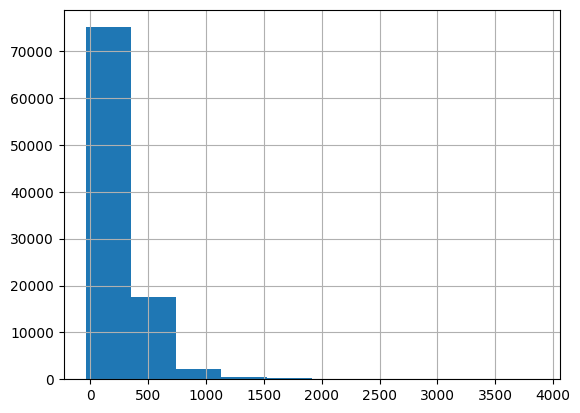

In [ ]:
#Ploting histogram of Profit
cible.hist()

It's evident that the resell market is highly lucrative, with most profits averaging around \$250 per shoe and reaching up to \$700. While negative profits occasionally occur, they are typically minimal, hovering around just over \$10. Conversely, exceptionally high profits are also observed, nearing \$1900 in rare cases.


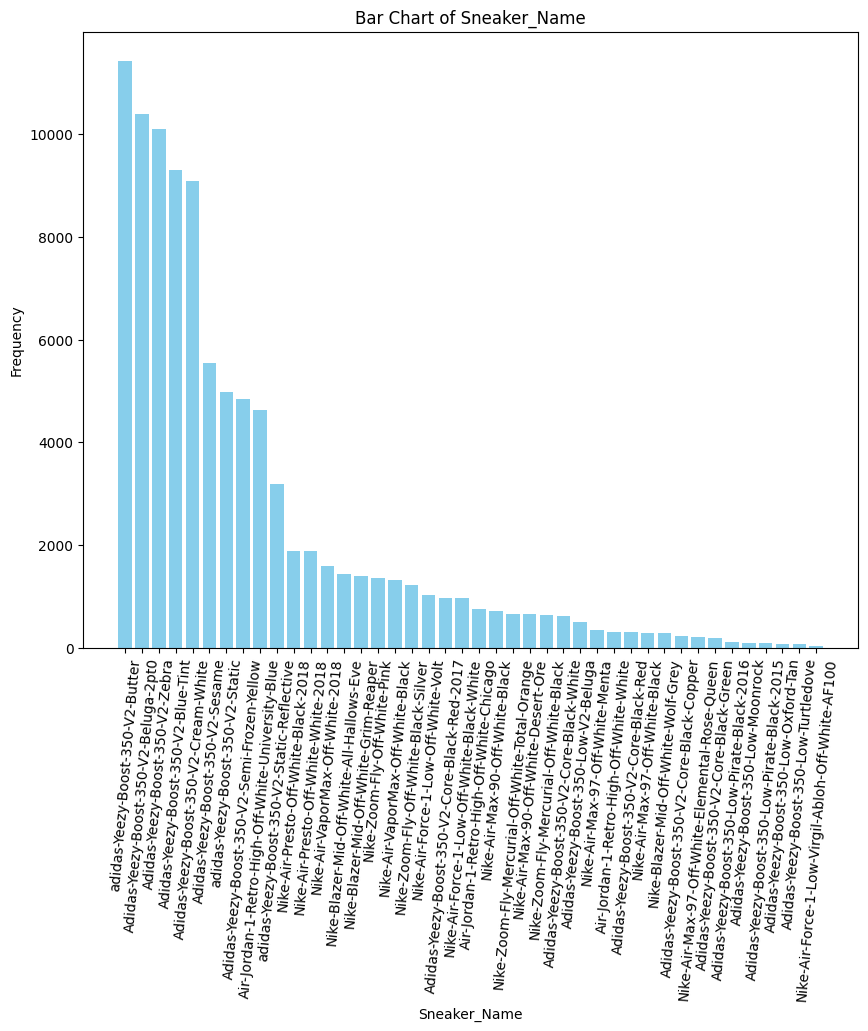

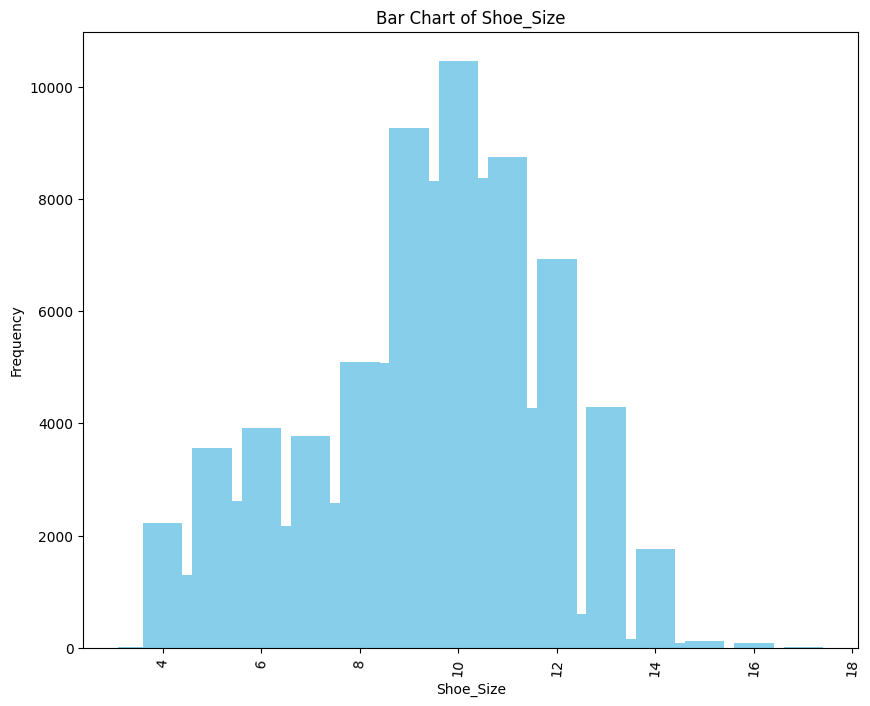

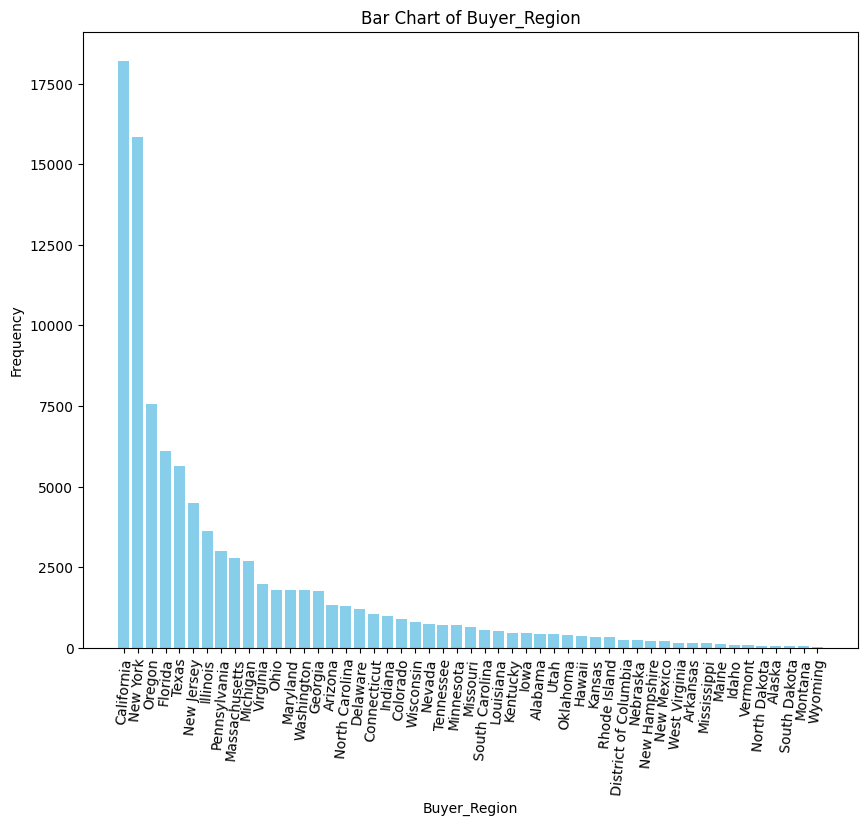

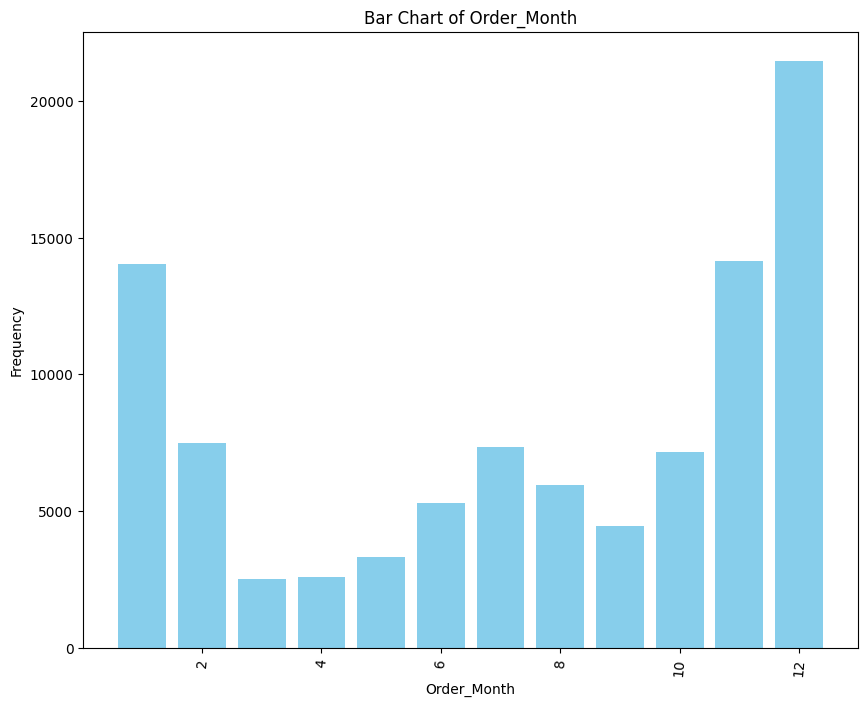

In [ ]:
#Ploting histogram of the dataset's feature

Feature = ['Sneaker_Name','Shoe_Size', 'Buyer_Region', 'Order_Month']

n=len(Feature)
i=1
for name in Feature:
    i+=1
    valeurs_count = df[name].value_counts()
    plt.figure(figsize=(10, 8))
    plt.bar(valeurs_count.index, valeurs_count.values, color='skyblue')
    plt.title(f'Bar Chart of {name}')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.xticks(rotation=85)
    plt.show()

Let's delve into the analysis of these plots. Firstly, it's evident that the Yeezy V2 Butter dominates as the most resold shoe, with the next ten top-selling shoes also being Yeezys. Interestingly, non-Yeezy shoes peak at the 11th position in terms of resale volume.

Moreover, we observe a predictable pattern in the distribution of shoe sizes, resembling a Gaussian distribution centered around size 10 (size 44 in France). This size is popular among both men (and some women), contributing to its frequent resale.

However, purchasing resold shoes tends to be costly for the average consumer. Typically, individuals splurge more on expensive items during holidays or throughout the year, indicating higher disposable income. Consequently, California emerges as the top consumer state, renowned for its affluence, followed by New York with a considerable gap. Other states collectively consume less than half of California's volume. Notably, most orders are concentrated around the Christmas season, spanning December and January.

Finally, an intriguing observation is that the majority of shoes are either purchased for resale on the drop's first day or more than two years after release.

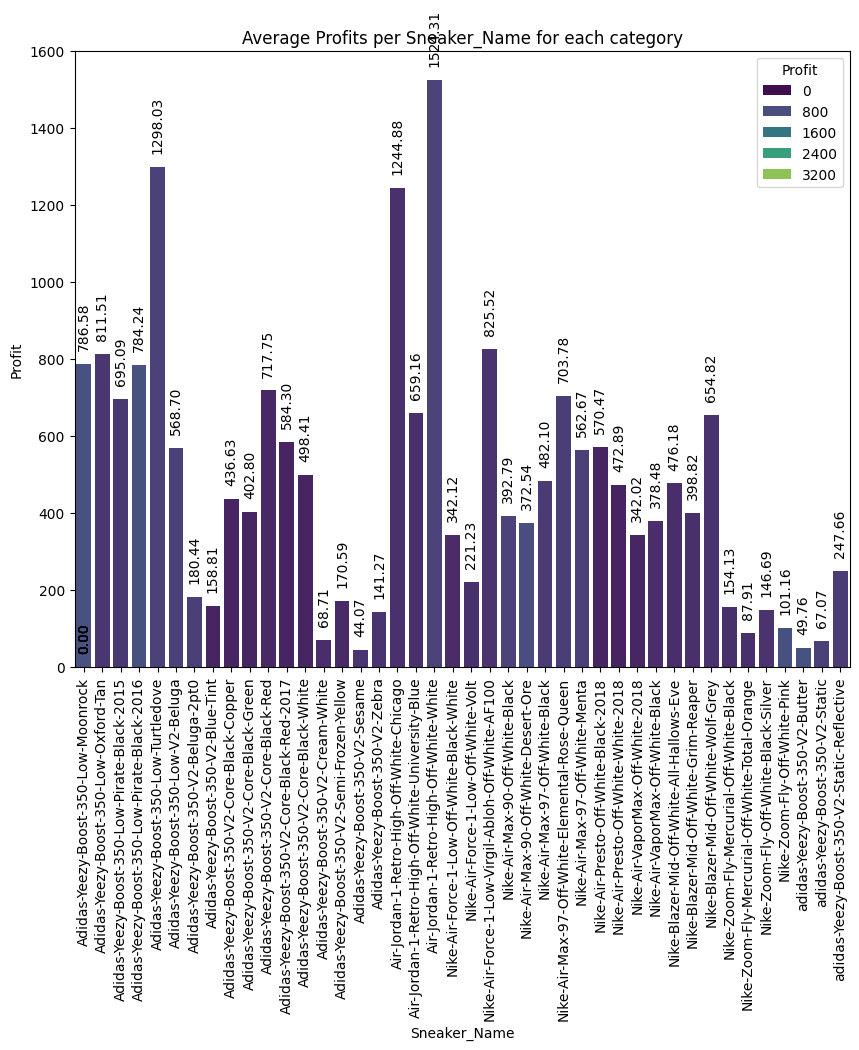

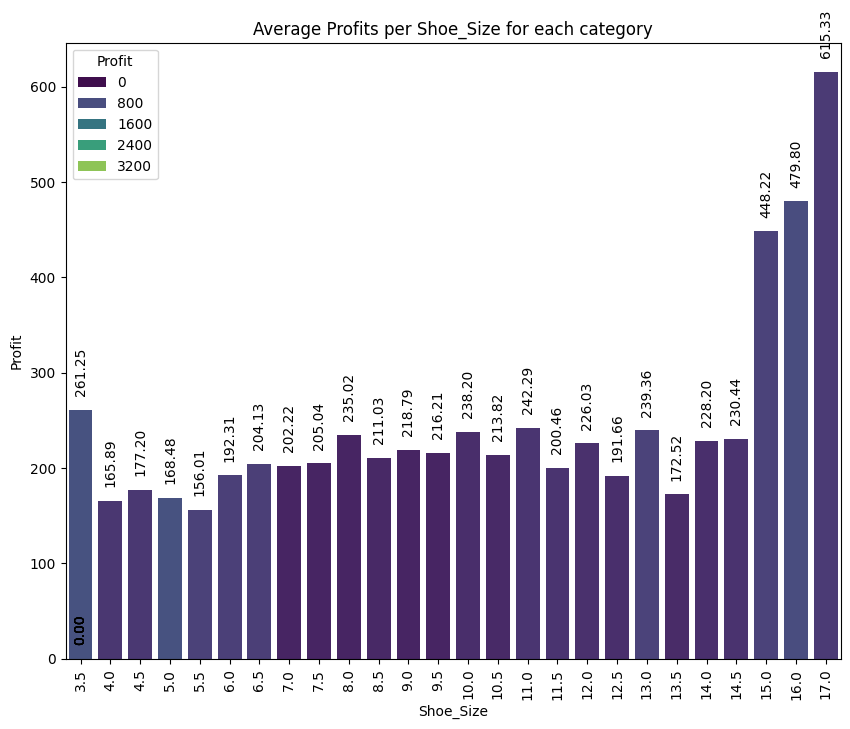

In [ ]:
#Ploting Profit in terms of the dataset's key features
Feature = ['Sneaker_Name', 'Shoe_Size']

for name in Feature:
    #Computing mean of profit per feature
    avg_profit_by_category = df.groupby(name)['Profit'].mean().reset_index()

    # Plot
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x=name, y='Profit', hue=cible, data=avg_profit_by_category, palette='viridis')

    #Print according mean on top of each feature
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', rotation=90)

    plt.title(f'Average Profits per {name} for each category')
    plt.xticks(rotation=90)
    plt.show()

Let's delve into the analysis of profit for each category.

Firstly, despite Off-White shoes ranking 11th in terms of resale volume, the two most profitable shoes by a significant margin are Off-White models: the Jordan 1 Retro High Off-White Chicago and the Jordan 1 Retro High Off-White.

Interestingly, shoe size appears to maintain a consistent impact on added value, with the exception of size 15 and above, which likely commands a premium due to its rarity.

### correlation between feature and target

<ipython-input-19-cebfcec75c6f>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = np.abs(DF.corr())


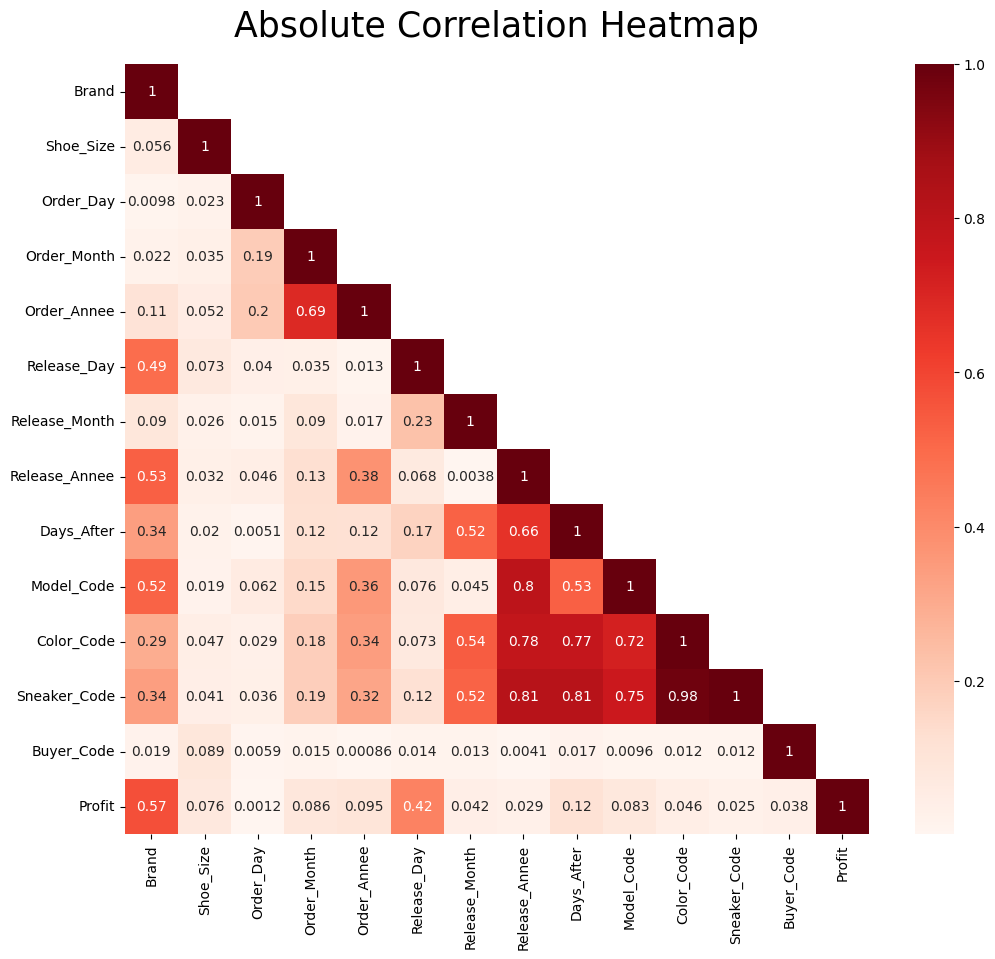

In [ ]:
# Ploting Correlation Matrix with absolute value of each feature
X = df.drop(columns=['Profit', 'Sneaker_Name', 'Buyer_Region', 'Model', 'Color'])
y = cible
DF = pd.concat([X, y], axis=1)
corr = np.abs(DF.corr())

# Mask upper triangle of the correlation matrix excluding the diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

plt.figure(figsize=(12, 10))
corrplot = sns.heatmap(corr, annot=True, cmap="Reds", mask=mask)
corrplot.set_title('Absolute Correlation Heatmap', fontdict={'fontsize': 25}, pad=20)
plt.show()

In [ ]:
#Printing correlation matrix
corr

,Brand,Shoe_Size,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After,Model_Code,Color_Code,Sneaker_Code,Buyer_Code,Profit
Brand,1.000000,0.056166,0.009784,0.022266,0.109881,0.490441,0.089690,0.526558,0.339740,0.518277,0.294608,0.338992,0.018771,0.571740
Shoe_Size,0.056166,1.000000,0.023187,0.035011,0.051845,0.072944,0.026041,0.032402,0.020449,0.018661,0.047365,0.040636,0.089262,0.075521
Order_Day,0.009784,0.023187,1.000000,0.192191,0.203774,0.039724,0.015314,0.045612,0.005128,0.062033,0.028709,0.035701,0.005870,0.001161
Order_Month,0.022266,0.035011,0.192191,1.000000,0.689540,0.034501,0.089605,0.127605,0.124396,0.148098,0.184970,0.185189,0.015153,0.085650
Order_Annee,0.109881,0.051845,0.203774,0.689540,1.000000,0.012536,0.017247,0.375946,0.118965,0.356410,0.342561,0.317697,0.000863,0.095236
Release_Day,0.490441,0.072944,0.039724,0.034501,0.012536,1.000000,0.230287,0.067861,0.170151,0.075912,0.072602,0.121303,0.014473,0.424644
Release_Month,0.089690,0.026041,0.015314,0.089605,0.017247,0.230287,1.000000,0.003782,0.522605,0.044785,0.536668,0.518938,0.012953,0.042460
Release_Annee,0.526558,0.032402,0.045612,0.127605,0.375946,0.067861,0.003782,1.000000,0.658889,0.798541,0.781282,0.813133,0.004095,0.029369
Days_After,0.339740,0.020449,0.005128,0.124396,0.118965,0.170151,0.522605,0.658889,1.000000,0.526964,0.773565,0.813295,0.016892,0.117129
Model_Code,0.518277,0.018661,0.062033,0.148098,0.356410,0.075912,0.044785,0.798541,0.526964,1.000000,0.722311,0.747787,0.009634,0.082703


In [ ]:
# Outputting the features exhibiting the highest and lowest correlation with profit
c_df = X.copy()
c_df["target"] = y.copy()
c_df_corr = c_df.corr()

# Sorting correlation values in descending order
best_corr = c_df_corr["target"].sort_values(ascending=False)

# Extracting the 5 most correlated variables (excluding the target variable)
top_5_least_correlated = best_corr[1:6]
top_5_least_correlated_info = [(name, corr) for name, corr in zip(top_5_least_correlated.index, top_5_least_correlated.values)]

# Extracting the 5 least correlated variables (excluding the target variable)
top_5_most_correlated = best_corr[-5:]
top_5_most_correlated_info = [(name, corr) for name, corr in zip(top_5_most_correlated.index, top_5_most_correlated.values)]

top_5_most_correlated_info, top_5_least_correlated_info


<ipython-input-21-79d68a1c5371>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c_df_corr = c_df.corr()


([('Order_Month', -0.08564992324506822),
  ('Order_Annee', -0.09523615575896094),
  ('Days_After', -0.11712884854893578),
  ('Release_Day', -0.42464394516886395),
  ('Brand', -0.5717397644505772)],
 [('Model_Code', 0.08270261886216212),
  ('Shoe_Size', 0.07552132192814236),
  ('Release_Annee', 0.029368566435697005),
  ('Order_Day', -0.0011607573969124696),
  ('Sneaker_Code', -0.024739039415344034)])

The correlation coefficients between the target variable "Profit" and various features reveal diverse associations. "Release_Day" and "Brand" exhibit strong negative correlations with profit, indicating significant impacts of the release day and sneaker brand on resale values. Similarly, "Days_After" displays a moderate negative correlation, suggesting that longer periods between release and resale may lead to decreased profits. Conversely, "Model_Code" and "Shoe_Size" show weak positive correlations with profit, implying that specific sneaker models and larger or smaller shoe sizes may influence resale prices to some extent. Other features such as "Order_Month", "Order_Year", "Release_Year", "Order_Day", and "Sneaker_Code" demonstrate relatively weaker or negligible correlations with profit. These observations provide valuable insights into factors influencing resale profits and may guide strategic decisions in the resale market.

In [ ]:
#Deleting outliers
colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

df_scores_z = df[colonnes_numeriques].apply(zscore)

seuil_score_z = 6

df_without_outliers = df[(df_scores_z.abs() < seuil_score_z).all(axis=1)]

df_without_outliers.head()

,Order_Date,Brand,Sneaker_Name,Release_Date,Shoe_Size,Buyer_Region,Profit,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After,Model,Color,Model_Code,Color_Code,Sneaker_Code,Buyer_Code
0,2017-09-01,1,Adidas-Yeezy-Boost-350-Low-V2-Beluga,2016-09-24,11.0,California,877,1,9,2017,24,9,2016,342,Adidas-Yeezy-Boost-350-Low-V2,Beluga,0,0,0,0
1,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,2016-11-23,11.0,California,465,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Copper,1,1,1,0
2,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,2016-11-23,11.0,California,470,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Green,1,2,2,0
3,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,2016-11-23,11.5,Kentucky,855,1,9,2017,23,11,2016,282,Adidas-Yeezy-Boost-350-V2,Core-Black-Red,1,3,3,1
4,2017-09-01,1,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,2017-02-11,11.0,Rhode Island,608,1,9,2017,11,2,2017,202,Adidas-Yeezy-Boost-350-V2--2017,Core-Black-Red,2,3,4,2


In [ ]:
#Removing outliers in the df
merged_df = df.merge(df_without_outliers, how='left', indicator=True)

df_not_in_outliers = merged_df[merged_df['_merge'] == 'left_only']

df_not_in_outliers = df_not_in_outliers.drop(columns=['_merge'])

print(df.shape[0]-df_without_outliers.shape[0],'outliers removed')

362 outliers removed


In [ ]:
df=df_without_outliers.copy()

# III) Training

In [ ]:
#selection of the data frame without the factored variables, which we will transform into dummys
df_subset = df.iloc[:, :16].copy()

In [ ]:
df_subset = pd.get_dummies(df_subset, columns=['Brand','Sneaker_Name','Buyer_Region','Model','Color'], drop_first=True)

df_y = df_subset.pop('Profit')
df_X = df_subset.drop(['Order_Date', 'Release_Date'], axis=1)
df_X.head()

,Shoe_Size,Order_Day,Order_Month,Order_Annee,Release_Day,Release_Month,Release_Annee,Days_After,Brand_1,Sneaker_Name_Adidas-Yeezy-Boost-350-Low-Oxford-Tan,...,Color_Sesame,Color_Static,Color_Static-Reflective,Color_Total-Orange,Color_Turtledove,Color_University-Blue,Color_Volt,Color_White,Color_Wolf-Grey,Color_Zebra
0,11.0,1,9,2017,24,9,2016,342,1,0,...,0,0,0,0,0,0,0,0,0,0
1,11.0,1,9,2017,23,11,2016,282,1,0,...,0,0,0,0,0,0,0,0,0,0
2,11.0,1,9,2017,23,11,2016,282,1,0,...,0,0,0,0,0,0,0,0,0,0
3,11.5,1,9,2017,23,11,2016,282,1,0,...,0,0,0,0,0,0,0,0,0,0
4,11.0,1,9,2017,11,2,2017,202,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

LinearRegression:
Mean Squared Error: 5919.05
R² on Training Set: 0.88
R² on Test Set: 0.88
Cross-validation score: 0.878698439491355


LinearRegression - Top 5 Feature Importance:
Order_Annee: 4500.2007
Sneaker_Name_Adidas-Yeezy-Boost-350-Low-Turtledove: 484.9916
Color_Turtledove: 484.9916
Order_Month: 372.2137
Model_Air-Jordan-1-Retro-High-Off-White: 352.5911




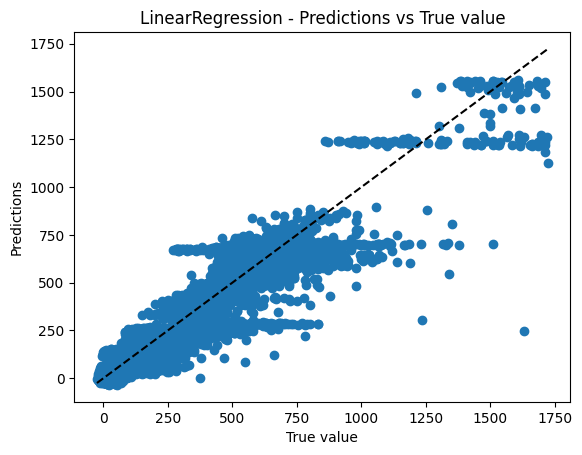

Ridge:
Mean Squared Error: 5946.88
R² on Training Set: 0.88
R² on Test Set: 0.88
Cross-validation score: 0.8780124394253546


Ridge - Top 5 Feature Importance:
Model_Air-Jordan-1-Retro-High-Off-White: 310.3924
Sneaker_Name_Air-Jordan-1-Retro-High-Off-White-White: 283.5117
Color_White: 283.5117
Sneaker_Name_Adidas-Yeezy-Boost-350-Low-Turtledove: 238.7079
Color_Turtledove: 238.7079




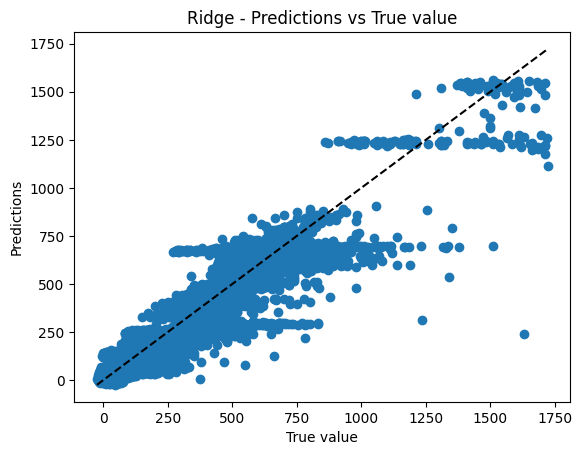

Lasso:
Mean Squared Error: 8379.90
R² on Training Set: 0.83
R² on Test Set: 0.83
Cross-validation score: 0.8313412719286557


Lasso - Top 5 Feature Importance:
Model_Air-Jordan-1-Retro-High-Off-White: 316.9074
Sneaker_Name_Air-Jordan-1-Retro-High-Off-White-White: 237.8014
Sneaker_Name_Nike-Air-Presto-Off-White-Black-2018: 212.2853
Model_Nike-Air-Max-97-Off-White: 128.4105
Sneaker_Name_adidas-Yeezy-Boost-350-V2-Static-Reflective: 126.9041




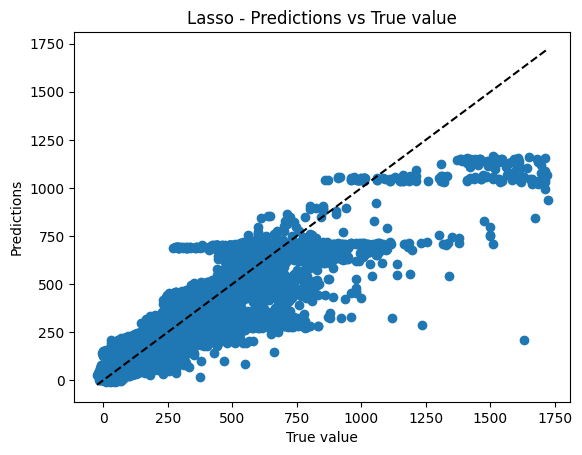

RandomForestRegressor:
Mean Squared Error: 621.74
R² on Training Set: 1.00
R² on Test Set: 0.99
Cross-validation score: 0.9868176995743632


RandomForestRegressor - Top 5 Feature Importance:
Brand_1: 0.3555
Model_Air-Jordan-1-Retro-High-Off-White: 0.1279
Release_Annee: 0.1034
Days_After: 0.0730
Release_Day: 0.0659




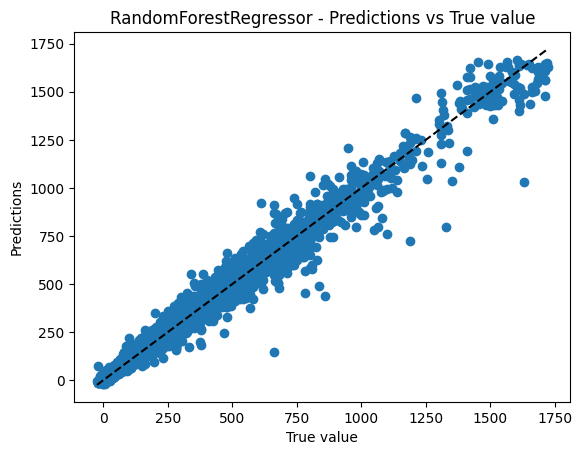

DecisionTreeRegressor:
Mean Squared Error: 949.76
R² on Training Set: 1.00
R² on Test Set: 0.98
Cross-validation score: 0.9796803221383641


DecisionTreeRegressor - Top 5 Feature Importance:
Brand_1: 0.3558
Model_Air-Jordan-1-Retro-High-Off-White: 0.1282
Release_Annee: 0.1063
Release_Day: 0.0972
Days_After: 0.0711




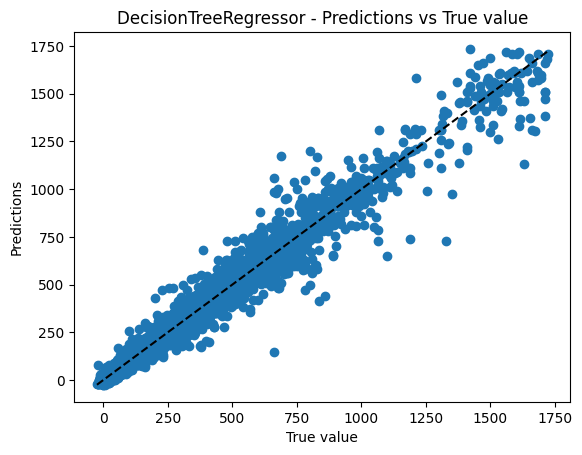

In [ ]:
#Ignore the convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

for model in models:
    #Train the model
    model.fit(X_train, y_train)

    #Prediction on the test set
    y_pred = model.predict(X_test)

    #Computing metrics
    mse = mean_squared_error(y_test, y_pred)
    r2_train = model.score(X_train, y_train)
    r2_test = r2_score(y_test, y_pred)
    cross_val = cross_val_score(model, X_train, y_train, cv=5).mean()

    # Printing metrics
    print(f"{type(model).__name__}:")
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R² on Training Set: {r2_train:.2f}')
    print(f'R² on Test Set: {r2_test:.2f}')
    print('Cross-validation score:', cross_val)
    print('\n')

    #Identifiyng the most significants features
    if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        if hasattr(model, 'coef_'):
            importance = model.coef_
        elif hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_

        features = df_X.columns
        feature_importance = dict(zip(features, importance))

        # Printing the 5 most significatives feature
        print(f"{type(model).__name__} - Top 5 Feature Importance:")
        for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"{feature}: {importance:.4f}")
        print("\n")

    #Ploting the test results after testing
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black')
    plt.xlabel("True value")
    plt.ylabel("Predictions")
    plt.title(f"{type(model).__name__} - Predictions vs True value")
    plt.show()

# Restore default warnings after code execution
warnings.filterwarnings("default", category=ConvergenceWarning)

# IV) Evaluation

In this analysis, multiple regression models were employed to predict outcomes in a dataset. The Linear Regression model achieved a Mean Squared Error of 8040.41, with R² scores of 0.86 on the training set and 0.87 on the test set. The model's cross-validation score was 0.86. The top 5 features influencing the Linear Regression model included Coloris_Zebra, Model_Adidas-Yeezy-Boost-350-V2--2017, and others.

The Ridge Regression model yielded a Mean Squared Error of 8106.77, matching the Linear Regression's R² scores and cross-validation score. The top 5 features influencing Ridge Regression included Model_Air-Jordan-1-Retro-High-Off-White, Coloris_White, and others.

Lasso Regression resulted in a Mean Squared Error of 10130.59, with slightly lower R² scores compared to the previous models. The top 5 influential features for Lasso included Sneaker_Name_Air-Jordan-1-Retro-High-Off-White-White, Sneaker_Name_Air-Jordan-1-Retro-High-Off-White-Chicago: this corresponds to the two models that generate the most profit, indicating that the model is too sensitive to these two models, which are significantly above the others in terms of profit.

Random Forest Regressor outperformed other models with a significantly lower Mean Squared Error of 790.00 and near-perfect R² scores. The top 5 features influencing Random Forest included Model_Air-Jordan-1-Retro-High-Off-White, Brand_1, and others.

Lastly, the Decision Tree Regressor achieved a Mean Squared Error of 1191.54, with high R² scores. The top 5 influential features for Decision Tree included Model_Air-Jordan-1-Retro-High-Off-White, Coloris_University-Blue, and others.

Based on the outcomes of our testing, the Random Forest Regressor emerged as the most suitable model for our supervised training task. Subsequently, a Randomized Search was conducted to identify the optimal hyperparameters for our chosen model.

In [ ]:
# Define the distribution of hyperparameters to search for
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Creating the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

#Use random search to find the best hyperparameters
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Printing best parameters
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Using model woth
best_rf_model = random_search.best_estimator_

# Training model on the train set
best_rf_model.fit(X_train, y_train)

# Evaluating trained model on the test set
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RandomForestRegressor with best hyperpameters - Mean Squared Error on the test set: {mse:.2f}")

Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
RandomForestRegressor with best hyperpameters - Mean Squared Error on the test set: 627.86


In [ ]:
#Printing its R^2
r2 = r2_score(y_test, y_pred)
print(f"RandomForestRegressor with best hyperpameters - R² on the test set: {r2:.2f}")

RandomForestRegressor with best hyperpameters - R² on the test set: 0.99


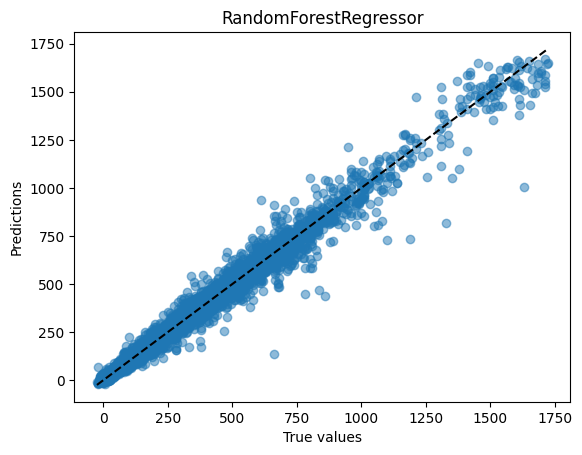

In [ ]:
#Ploting the results after using the fitted hyperparameters
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black')
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title("RandomForestRegressor")
plt.show()

The perceptible outcome post-fitting reveals a notable improvement in the model's predictions, aligning more closely with the actual profit values.

# Conclusion
We endeavored to conduct this analysis exclusively utilizing native Python packages, distinguishing our approach from others who rely on StockX-specific Python packages that are presently unavailable. Although the extraction of information from the dataset posed certain challenges, our code is designed to be adaptable and can be readily utilized by others for similar supervised learning tasks. Subsequently, our findings indicate that the RandomForestRegressor stands out as the optimal model for profit estimation, boasting a commendable validation score of 0.98.

Through this study, we have successfully conducted an estimation of the resell profit associated with various characteristics of a sneaker. As outlined in the introduction, substantial modifications were applied to the original dataset obtained from StockX. Our findings were subsequently validated through comparisons with other analyses, yielding consistent profit predictions.

To enhance the precision of this neural network, a more extensive extraction of features from the original dataset is recommended. For instance, incorporating variables such as the duration between the release and resell dates or utilizing unique identifiers for each shoe could contribute valuable insights. Notably, the unique identification of shoes, particularly distinguishing between versions (e.g., Nike Dunk Black Men and Women), has proven to impact their respective values in the reseller market. Furthermore, diversifying the dataset to encompass additional brands beyond Nike and Yeezy could enhance the generalizability of profit estimates.

The computational code developed for profit estimation is versatile and can be repurposed for various supervised learning tasks. However, it is pertinent to acknowledge the computational demands associated with executing the program within a reasonable timeframe. Notably, the section of the code where we iterated over different regression models required approximately 15 minutes for computation.

##Bonus: Boosting

We also tested two other models: GradientBoostingRegressor() and AdaBoostRegressor(), and found that they did not outperform the selected model.

GradientBoostingRegressor:
Mean Squared Error: 3718.71
R² on Test Set: 0.93




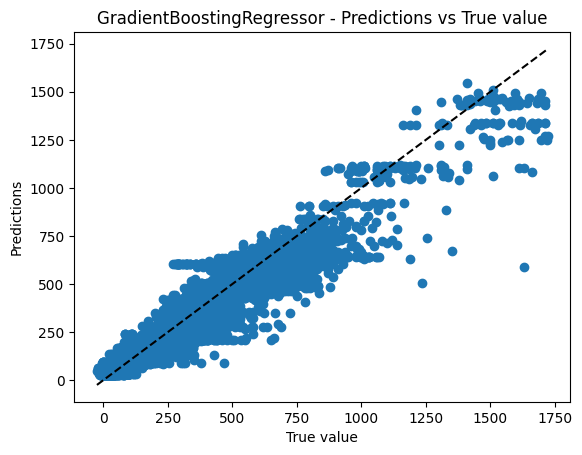

AdaBoostRegressor:
Mean Squared Error: 63074.80
R² on Test Set: -0.25




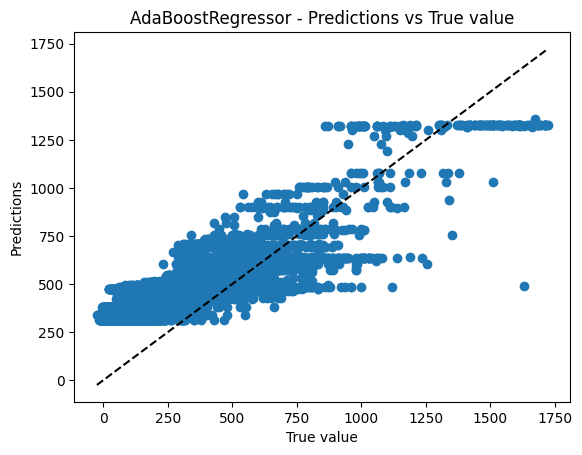

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Ajouter les modèles de boosting à la liste des modèles
models_boosting = [
    GradientBoostingRegressor(),
    AdaBoostRegressor()
]

for model in models_boosting:
    # Train the model
    model.fit(X_train, y_train)

    # Prediction on the test set
    y_pred = model.predict(X_test)

    # Compute metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Printing metrics
    print(f"{type(model).__name__}:")
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R² on Test Set: {r2:.2f}')
    print('\n')

    # Plotting the test results after testing
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black')
    plt.xlabel("True value")
    plt.ylabel("Predictions")
    plt.title(f"{type(model).__name__} - Predictions vs True value")
    plt.show()
